#### Import packages

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

from math import comb

import tqdm

import os

#### Microscope parameters

In [19]:
roi_x = 150 #nm
roi_y = 150 #nm
px_size = 40 #nm/px was 160

#### Import data

In [20]:
path = '../data/'

fname = os.path.join(path, '20211202_A673-U2#83_PA-JF646_STORM_cell-3.xlsx')
df = pd.read_excel(fname, header = 1, index_col = 'ID')

x_arr_nm = 1000 * np.array(df['X Position [µm]'])
y_arr_nm = 1000 * np.array(df['Y Position [µm]'])

x_arr_px = x_arr_nm/px_size
y_arr_px = y_arr_nm/px_size

#### EWS-FLI1 hub parameters
The hydrodynamic radius, `r_h` was taken as the [hydrodynamic radius converter's](https://www.fluidic.com/toolkit/hydrodynamic-radius-converter/) prediction for the unfolded state.

In [21]:
# Interaction radius of EWS-FLI1
r_h = 120 #nm

#### Initialize ROI

In [22]:
roi_x_nm = roi_x * px_size
roi_y_nm = roi_y * px_size
roi_arr_px = np.zeros((roi_x*4, roi_y*4)) #Shawn here
roi_arr_nm = np.zeros((roi_x_nm, roi_y_nm))

#### Cross visualization

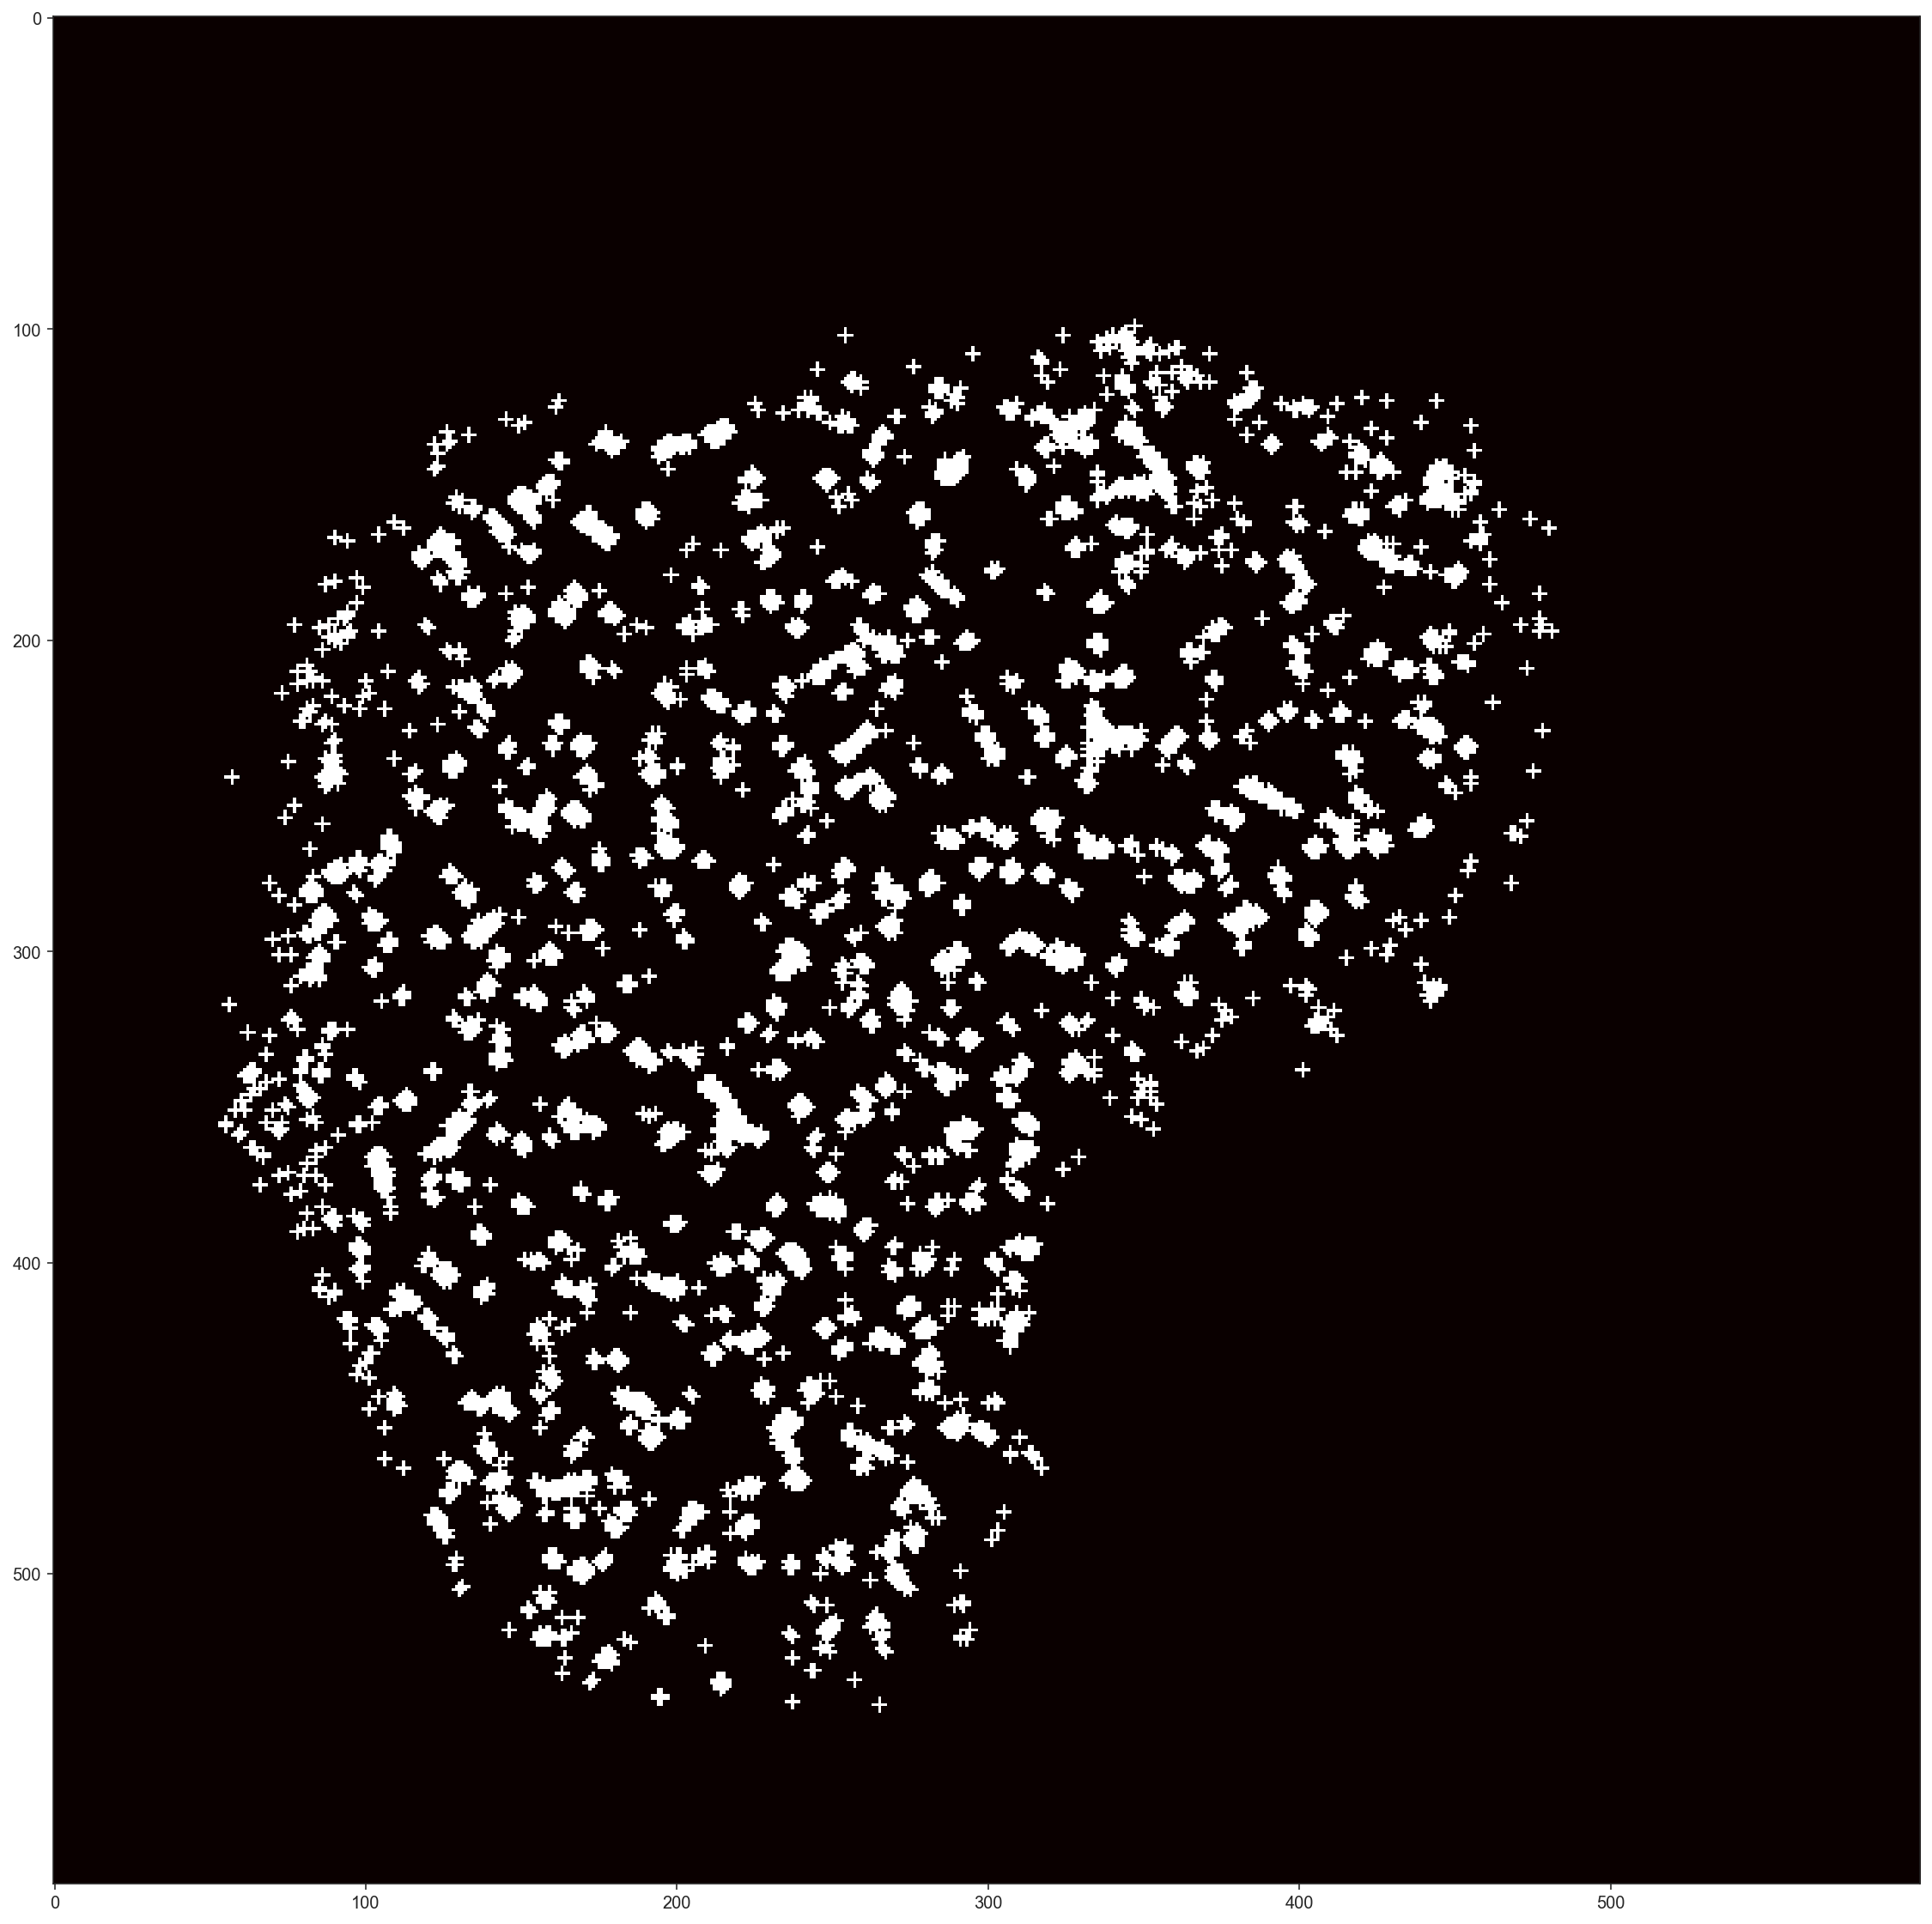

In [61]:
include_cross = True

cross_size = 2 #px in each direction from localization
roi_arr_px_cross = np.copy(roi_arr_px)

if include_cross == True:
    for i, j in zip(x_arr_px, y_arr_px):
        i_round, j_round = int(np.round(i)), int(np.round(j))
        for k in range(-cross_size, cross_size + 1):
            if ((i_round + k) < len(roi_arr_px)) and ((j_round + k) < len(roi_arr_px)):
                roi_arr_px_cross[i_round + k, j_round] = roi_arr_px_cross[i_round + k, j_round] + 1
                roi_arr_px_cross[i_round, j_round + k] = roi_arr_px_cross[i_round, j_round + k] + 1
            else:
                continue
    roi_arr_px_cross[roi_arr_px_cross > 0] = 1
    plt.figure(figsize = (20,20))
    plt.imshow(roi_arr_px_cross, cmap='hot')
    plt.show()          
    

#### Localization visualization

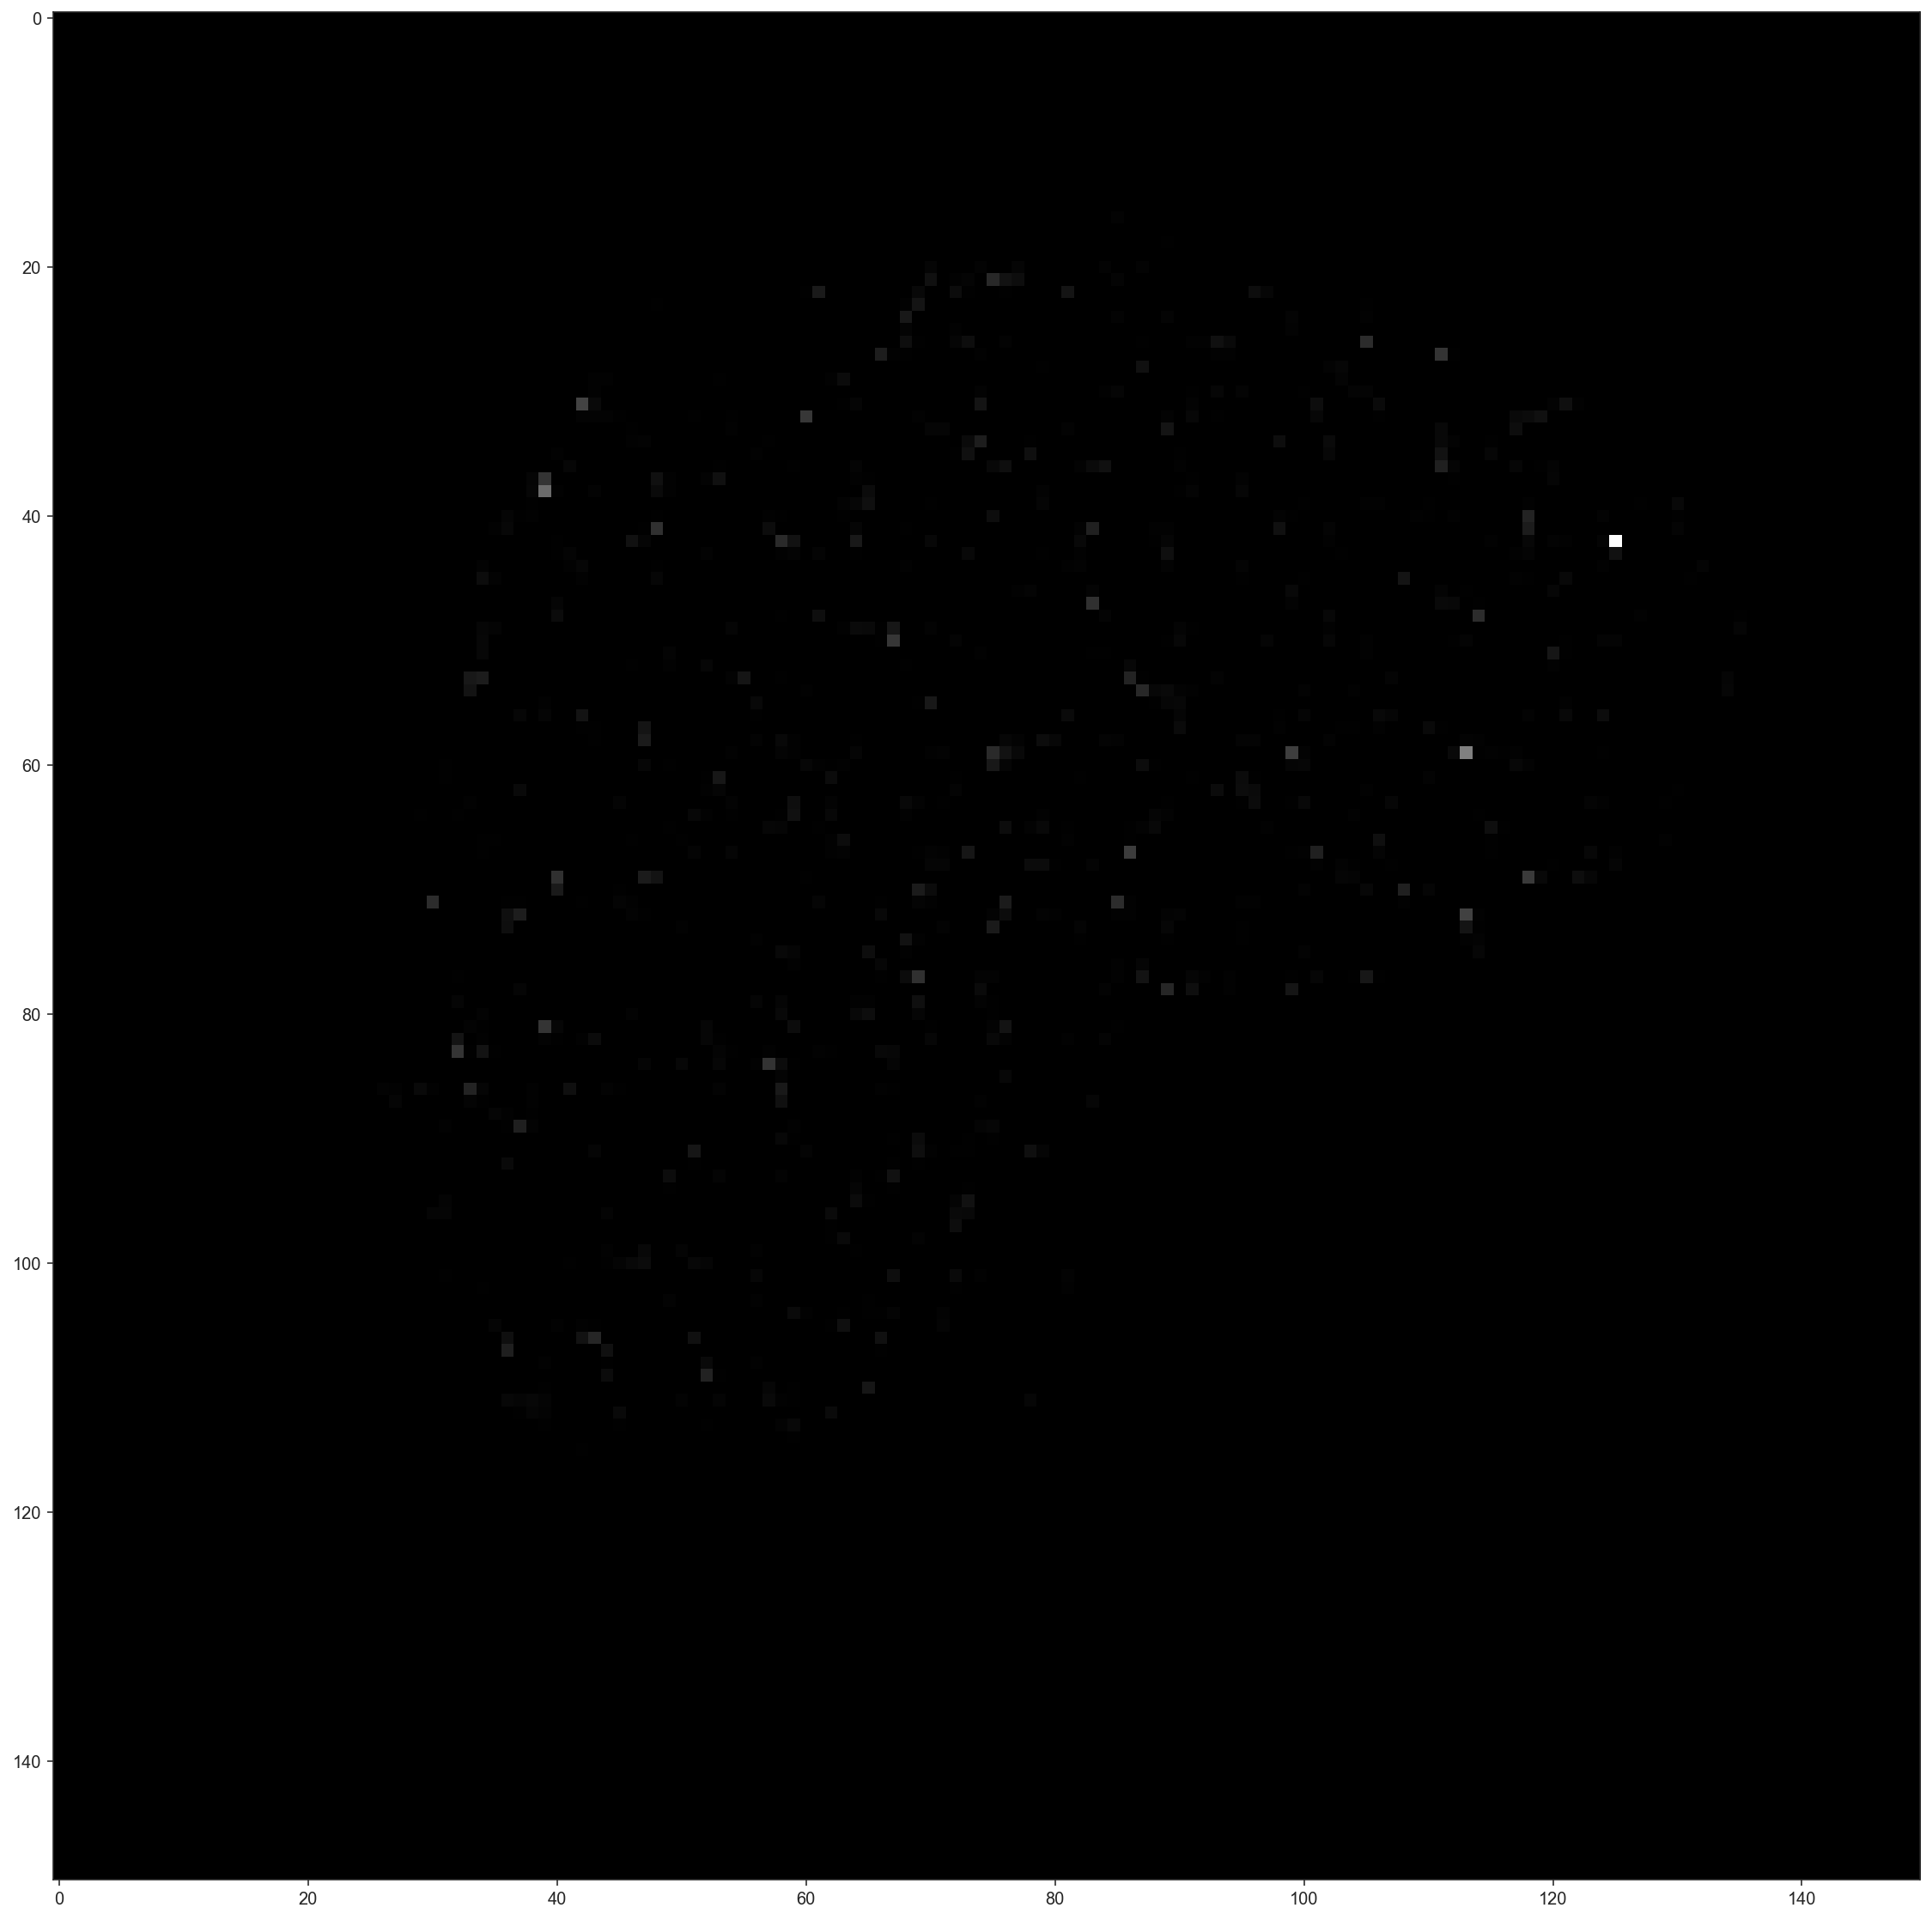

In [93]:
for i, j in zip(x_arr_px, y_arr_px):
    i_round, j_round = int(np.round(i)), int(np.round(j))
    roi_arr_px[i_round, j_round] = roi_arr_px[i_round, j_round] + 1

plt.figure(figsize = (20,20))
plt.imshow(np.transpose(roi_arr_px), cmap='gray')
plt.show()

#### Pair-correlation and linearized K-Ripley functions

In [31]:
def dist(x1, y1, x2, y2):
    '''
    Takes localization coordinates and
    returns distance between (x1, y1) and (x2, y2)
    '''
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def calc_N(my_arr, number):
    '''
    Takes an array and a number of localizations and
    returns the N (nearest neighbor) constant
    '''
    return np.sum(my_arr)/number

def calc_K(N, r, number):
    '''
    Takes N, r, and a number of localizations and
    returns Ripley's K constant
    '''
    return np.pi*(r**2)*N/(number - 1)

In [43]:
x_arr_nm = x_arr_nm[0:5000]
y_arr_nm = y_arr_nm[0:5000]

r_arr = np.linspace(0, 200, 51)
K_arr = np.zeros_like(r_arr)

x_list = x_arr_nm.tolist()
y_list = y_arr_nm.tolist()

num = len(x_list)

r_sent = 0
for r in r_arr:
    f_arr = np.zeros(shape = comb(num, 2))

    x_list = x_arr_nm.tolist()
    y_list = y_arr_nm.tolist()
    
    sent = 0
    for i, j in tqdm.tqdm(zip(x_list, y_list), total=len(x_list)/2, \
                          desc = 'r = ' + str(r), leave = False):
        for k, l in zip(x_list, y_list):
            if dist(i, j, k, l) > r:
                f_arr[sent] = 0
                sent = sent + 1
            else:
                f_arr[sent] = 1
                sent = sent + 1  
        x_list.remove(i)
        y_list.remove(j)    

    N = calc_N(f_arr, num)
    K = calc_K(N, r, num)
    K_arr[r_sent] = K
    r_sent = r_sent + 1

KeyboardInterrupt: 

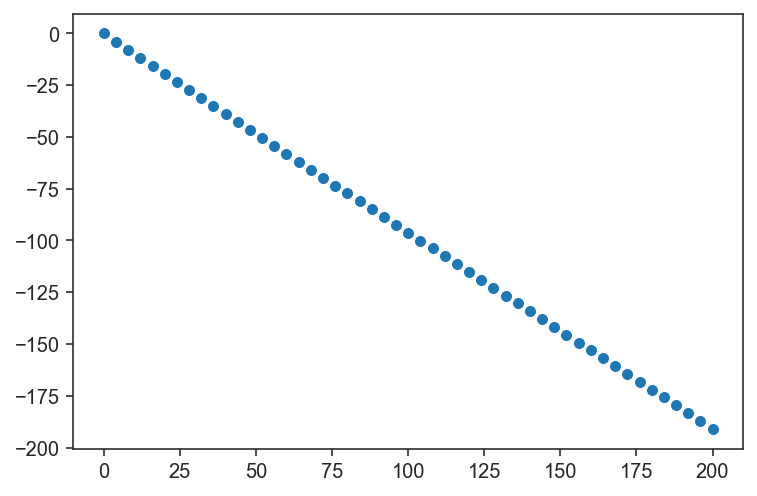

In [108]:
L_arr = np.sqrt((K_arr)/np.pi)
H_arr = L_arr - r_arr
sns.scatterplot(x = r_arr, y = H_arr);

#### Hub clustering

In [26]:
x_list = x_arr_nm.tolist()
y_list = y_arr_nm.tolist()

cluster = []
no_cluster = []

for i, j in tqdm.tqdm(zip(x_list, y_list), total=len(x_list)):
    new_cluster = []
    is_cluster = False
    x_list.remove(i)
    y_list.remove(j)
    cluster_centers_x = [i]
    cluster_centers_y = [j]
    for k, l in zip(x_list, y_list):
        in_cluster = False
        for m, n in zip(cluster_centers_x, cluster_centers_y):
            if ((m - k)**2 + (n - l)**2) < 2 * r_h:
                in_cluster = True
        if in_cluster == True:
            if is_cluster == False:
                is_cluster = True
                new_cluster.append([i, j])
                new_cluster.append([k, l])
                cluster_centers_x.append(k)
                cluster_centers_y.append(l)
            else:
                new_cluster.append([k, l])
                cluster_centers_x.append(k)
                cluster_centers_y.append(l)
                x_list.remove(k)
                y_list.remove(l)
            
    if is_cluster == False:
        no_cluster.append([i, j])
    else:
        cluster.append(new_cluster)
        new_cluster = []

 42%|███████████████▋                     | 12856/30398 [03:09<04:18, 67.82it/s]


#### Plot histogram

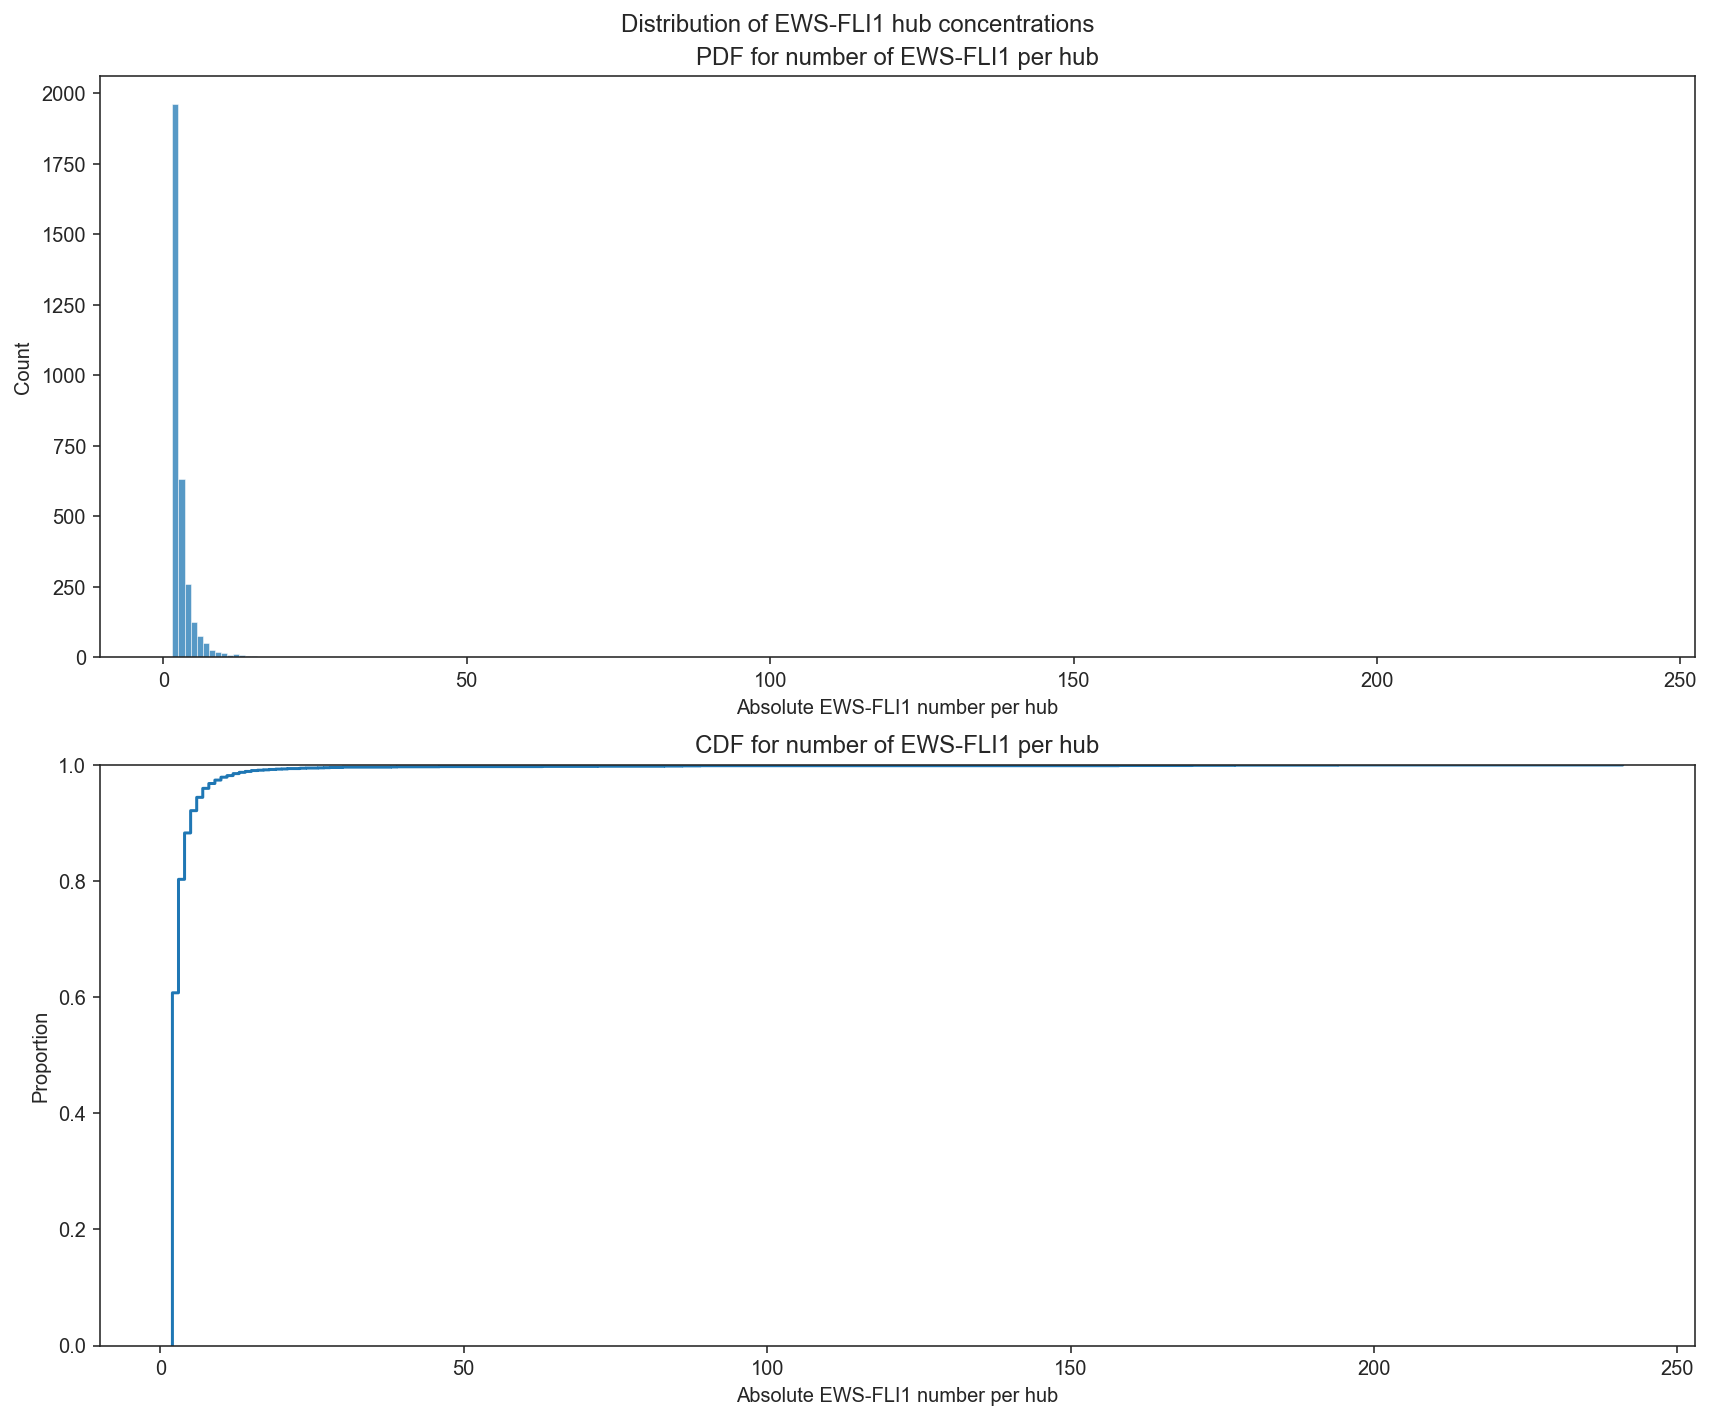

In [27]:
proteins_per_hub = []
for i in cluster:
    proteins_per_hub.append(len(i))
    
bins_list = np.arange(np.min(proteins_per_hub) - .5, np.max(proteins_per_hub) + .5, 1)

# Generate figure and title
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Distribution of EWS-FLI1 hub concentrations')

# Plot data from each channel on it's respective axis
sns.histplot(ax = axes[0], data = proteins_per_hub, bins = bins_list)
sns.ecdfplot(ax = axes[1], data = proteins_per_hub)

# Labeling subplots
axes[0].set_title('PDF for number of EWS-FLI1 per hub')
axes[1].set_title('CDF for number of EWS-FLI1 per hub')
axes[0].set_xlabel('Absolute EWS-FLI1 number per hub')
axes[1].set_xlabel('Absolute EWS-FLI1 number per hub');

plt.tight_layout()

#### Plot histogram of only hubs with more than five localization events

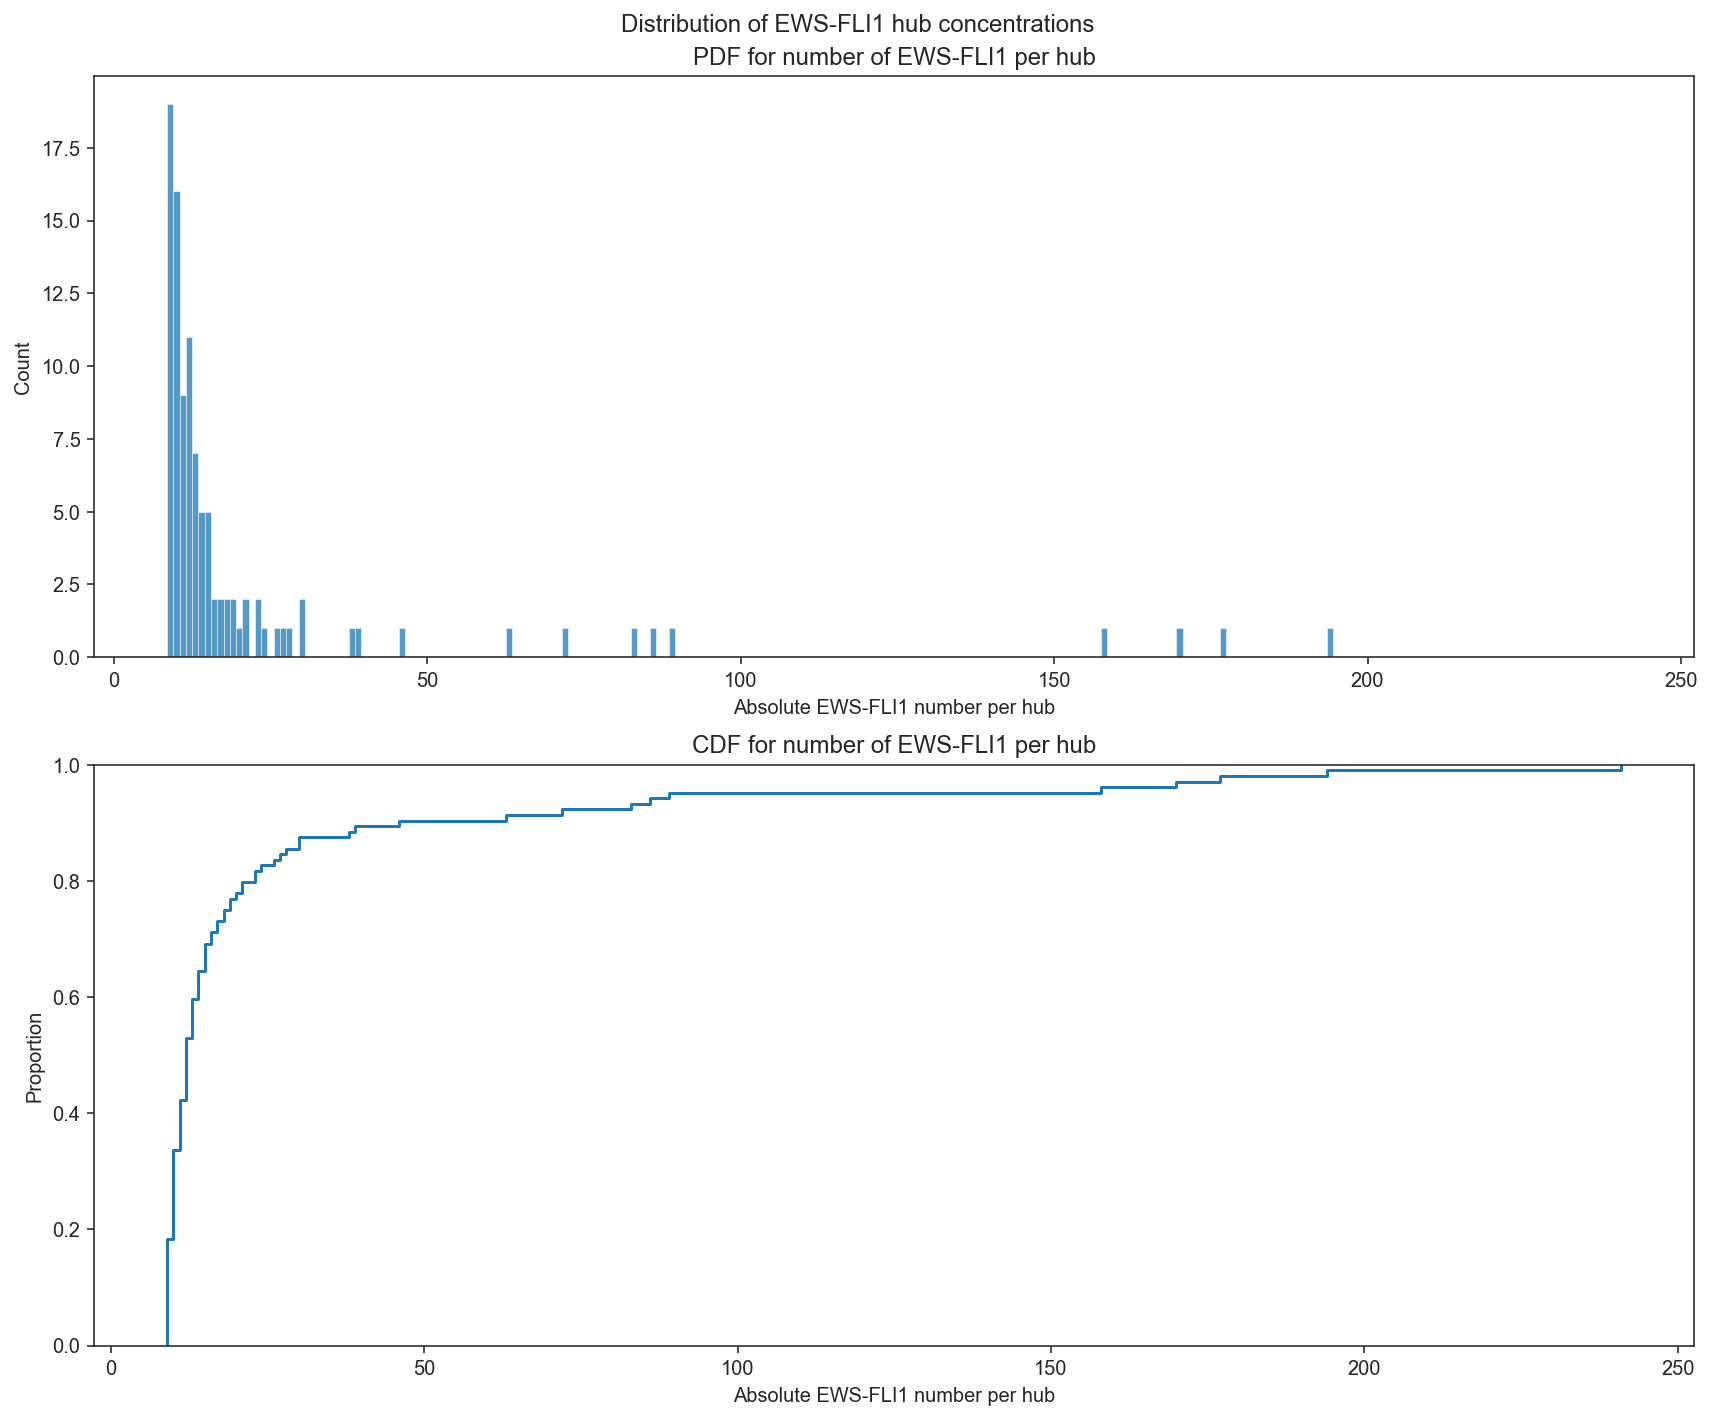

In [28]:
proteins_per_hub_over_five = [elem for elem in proteins_per_hub if elem > 8]
    
bins_list = np.arange(np.min(proteins_per_hub_over_five) - .5, \
                      np.max(proteins_per_hub_over_five) + .5, 1)

# Generate figure and title
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Distribution of EWS-FLI1 hub concentrations')

# Plot data from each channel on it's respective axis
sns.histplot(ax = axes[0], data = proteins_per_hub_over_five, bins = bins_list)
sns.ecdfplot(ax = axes[1], data = proteins_per_hub_over_five)

# Labeling subplots
axes[0].set_title('PDF for number of EWS-FLI1 per hub')
axes[1].set_title('CDF for number of EWS-FLI1 per hub')
axes[0].set_xlabel('Absolute EWS-FLI1 number per hub')
axes[1].set_xlabel('Absolute EWS-FLI1 number per hub');

plt.tight_layout()

#### Hub only visualization

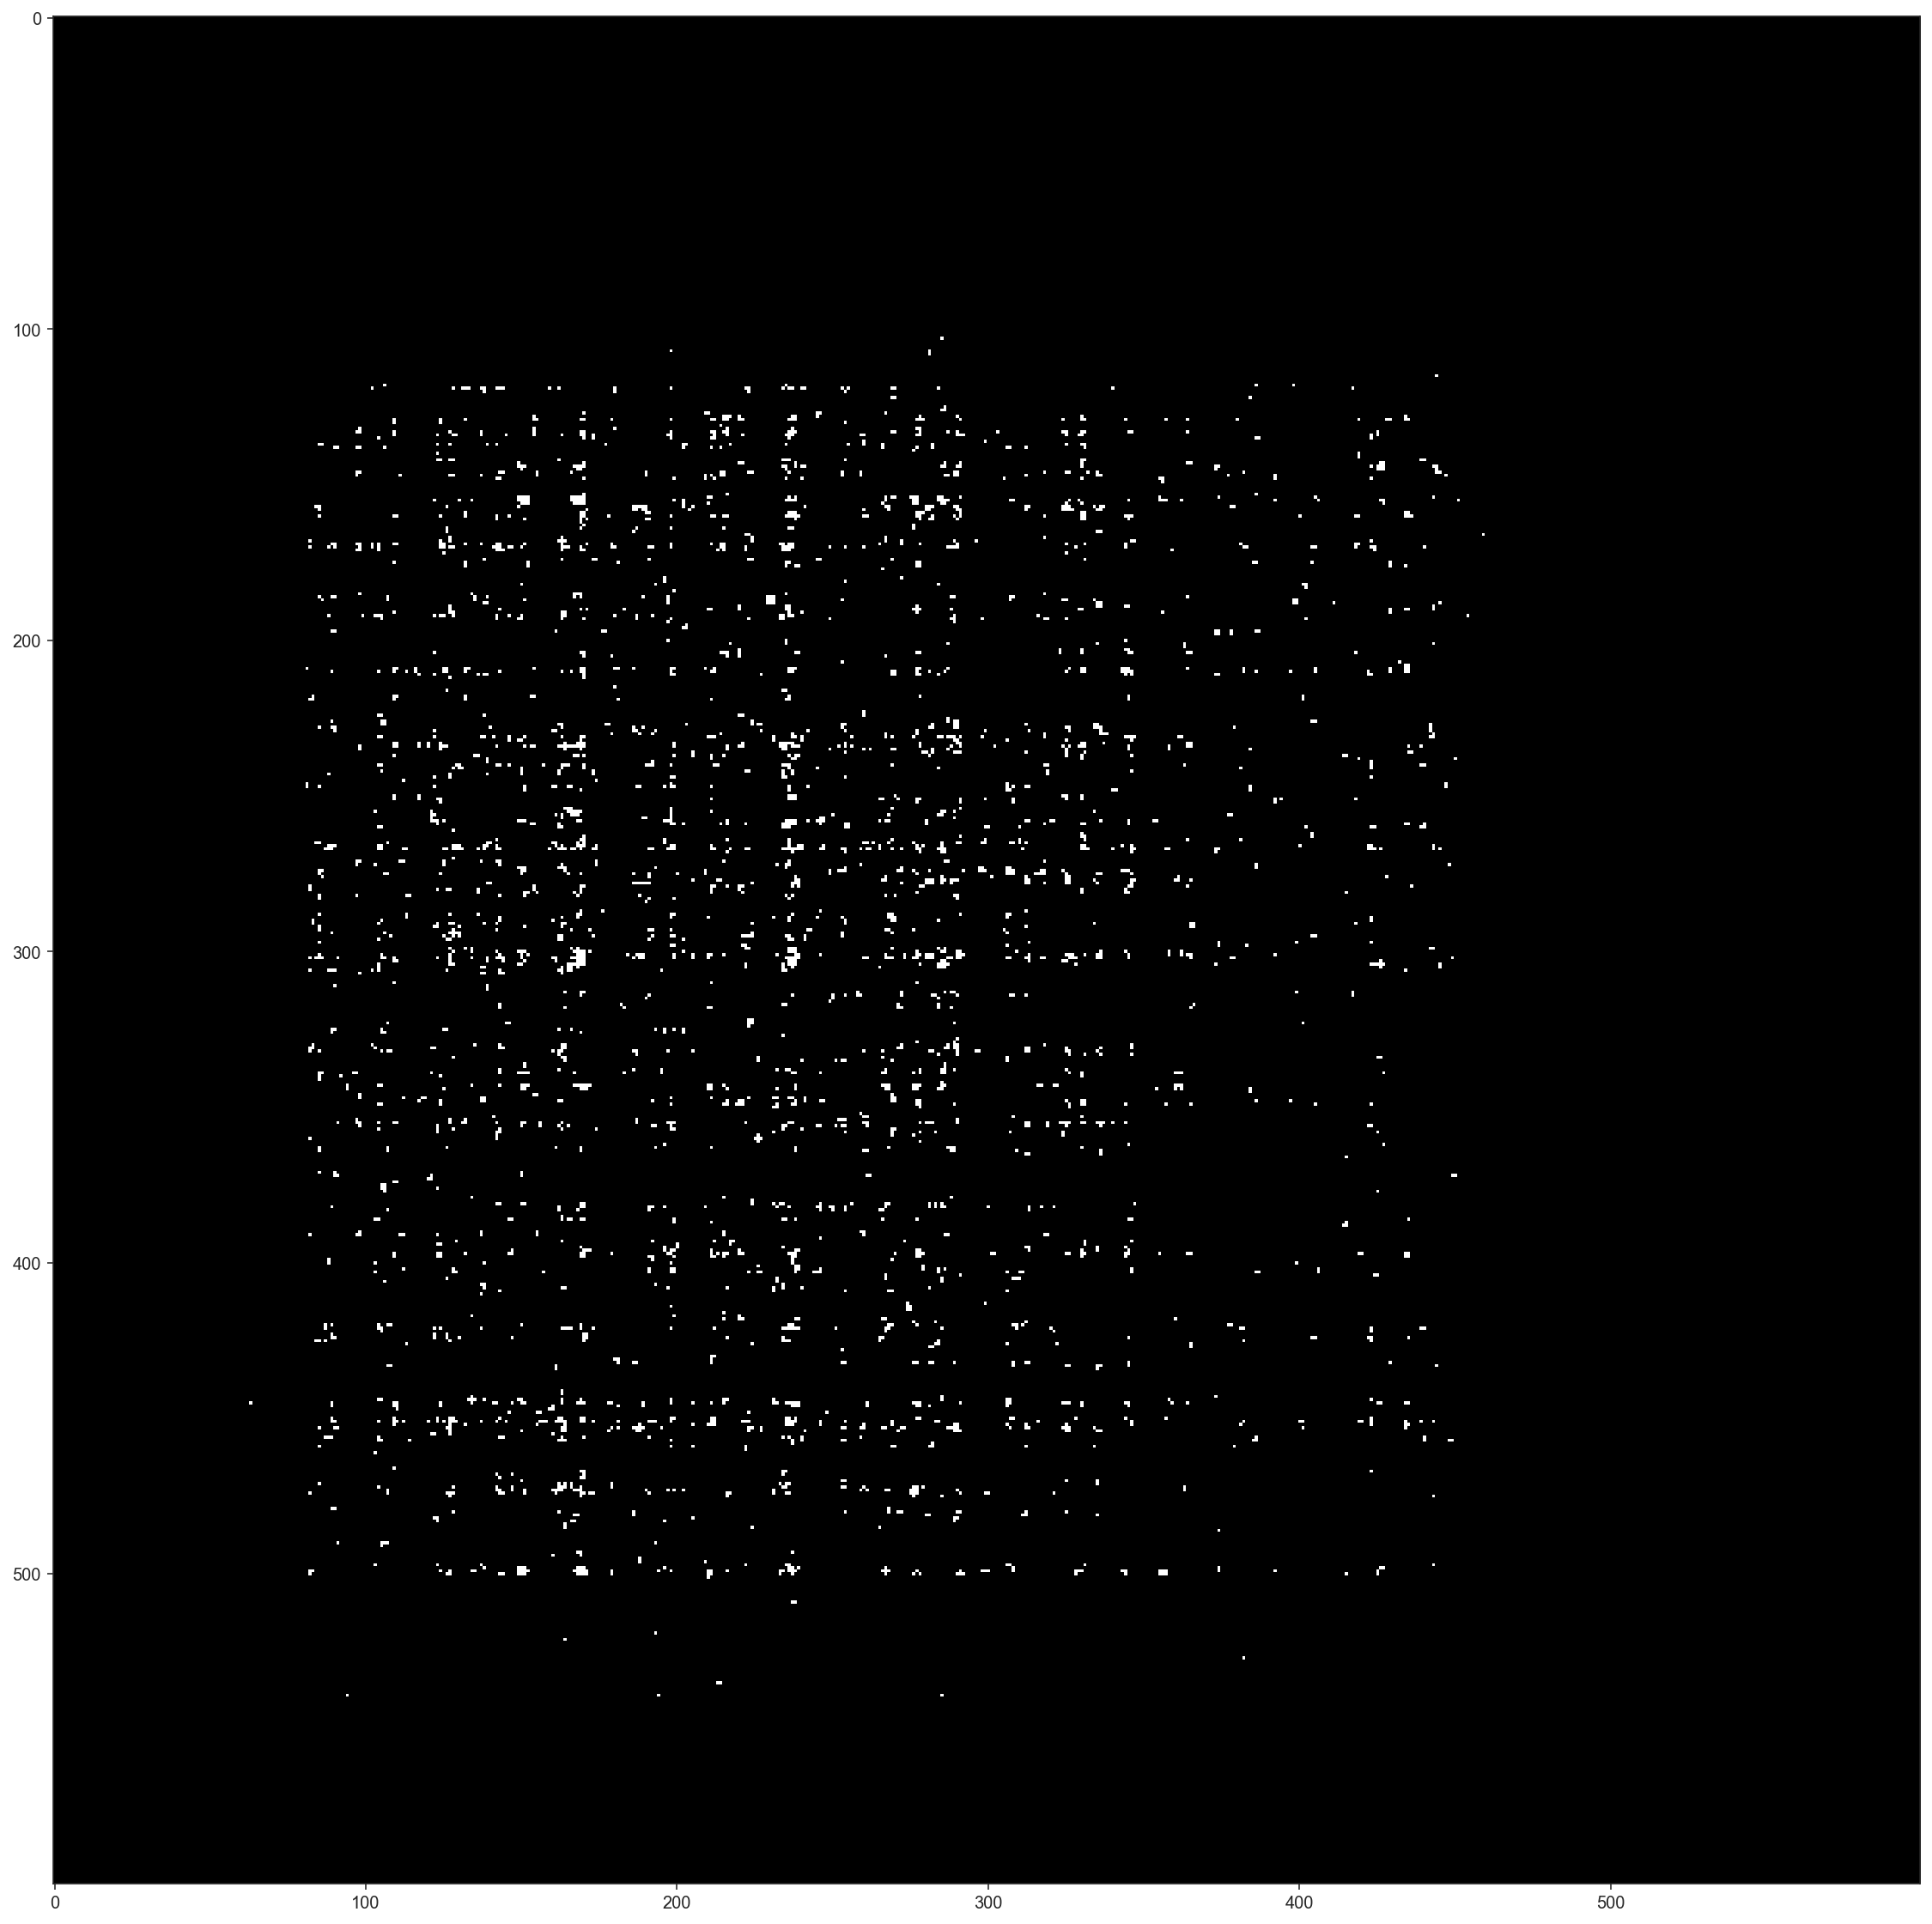

In [55]:
roi_arr_px_hub_only = np.zeros(np.shape(roi_arr_px))
x_arr_px_hub_only = []
y_arr_px_hub_only = []

for i in cluster:
    for j in i:
        x_arr_px_hub_only.append(j[0] / 40)
        y_arr_px_hub_only.append(j[1] / 40)      
        
for i, j in zip(x_arr_px_hub_only, y_arr_px_hub_only):
    i_round_hub_only, j_round_hub_only = int(np.round(i)), int(np.round(j))
    roi_arr_px_hub_only[i_round_hub_only, j_round_hub_only] = \
        roi_arr_px_hub_only[i_round_hub_only][j_round_hub_only] + 1

roi_arr_px_hub_only[roi_arr_px_hub_only > 0] = 1
plt.figure(figsize = (20,20))
plt.imshow(roi_arr_px_hub_only, cmap='gray')
plt.show()

In [12]:
%load_ext watermark
%watermark -a "Shawn Yoshida" -d -v -p jupyterlab --iversions

Author: Shawn Yoshida

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.27.0

jupyterlab: 3.1.7

matplotlib: 3.4.2
pandas    : 1.3.2
numpy     : 1.20.3
seaborn   : 0.11.2

